In [1]:
from utils import *
%matplotlib inline

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 7)

In [3]:
train_data, train_results, test_data, test_results = read_data()

In [41]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regressor_with_batches(train_data, train_results, test_data, prediction_mode='delta', **est_parameters):
    est = RandomForestRegressor(n_jobs=-1, random_state=0, warm_start=True, n_estimators=10, **est_parameters)
    
    if prediction_mode == 'delta':
        make_results = make_delta
        unmake_results = unmake_delta
    else:
        make_results = lambda train_data, train_results: train_results
        unmake_results = lambda test_data, prediction: prediction
    
    train_data_ = to_model_with_features(train_data)
    train_results_ = to_model(make_results(train_data, train_results))
    
    n_samples = train_data_.shape[0]
    batch_num = 3
    batch_size = int(n_samples/batch_num)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for i in range(batch_num):
        est.fit(train_data_[indices[i*batch_size:(i+1)*batch_size]], train_results_[indices[i*batch_size:(i+1)*batch_size]]) 
        est.n_estimators += 10
    
    prediction = unmake_results(test_data, from_model(est.predict(to_model_with_features(test_data))))
        
    return prediction

1/3: 2016-12-14 16:40:28
2/3: 2016-12-14 16:40:35
3/3: 2016-12-14 16:40:49
done! 2016-12-14 16:41:21
Results: [0.39011606743357119, 0.39355346905994826, 0.38705167074854463]


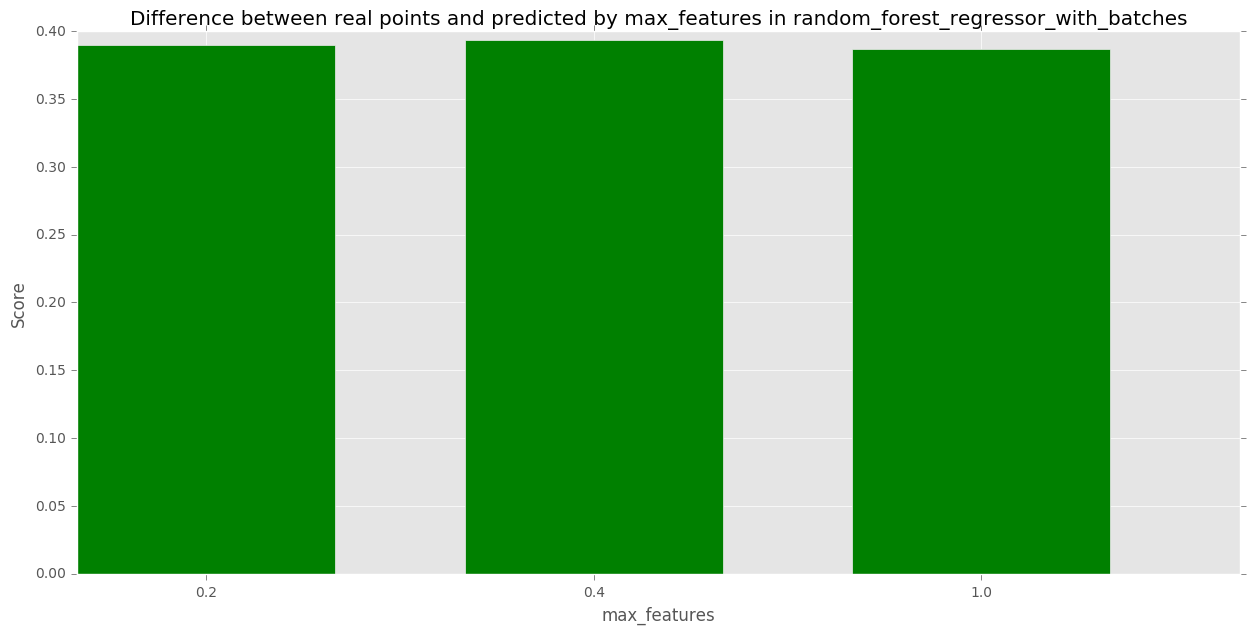

In [42]:
compare_results(function=random_forest_regressor_with_batches, test_results=test_results, parameter_name="max_features",
                list_of_values=[0.2, 0.4, 1.0], train_data=train_data, train_results=train_results,
                test_data=test_data, prediction_mode='delta')

1/3: 2016-12-14 16:41:22
2/3: 2016-12-14 16:41:31
3/3: 2016-12-14 16:41:46
done! 2016-12-14 16:42:21
Results: [0.63059116203955812, 0.63118133119290021, 0.62569750800476642]


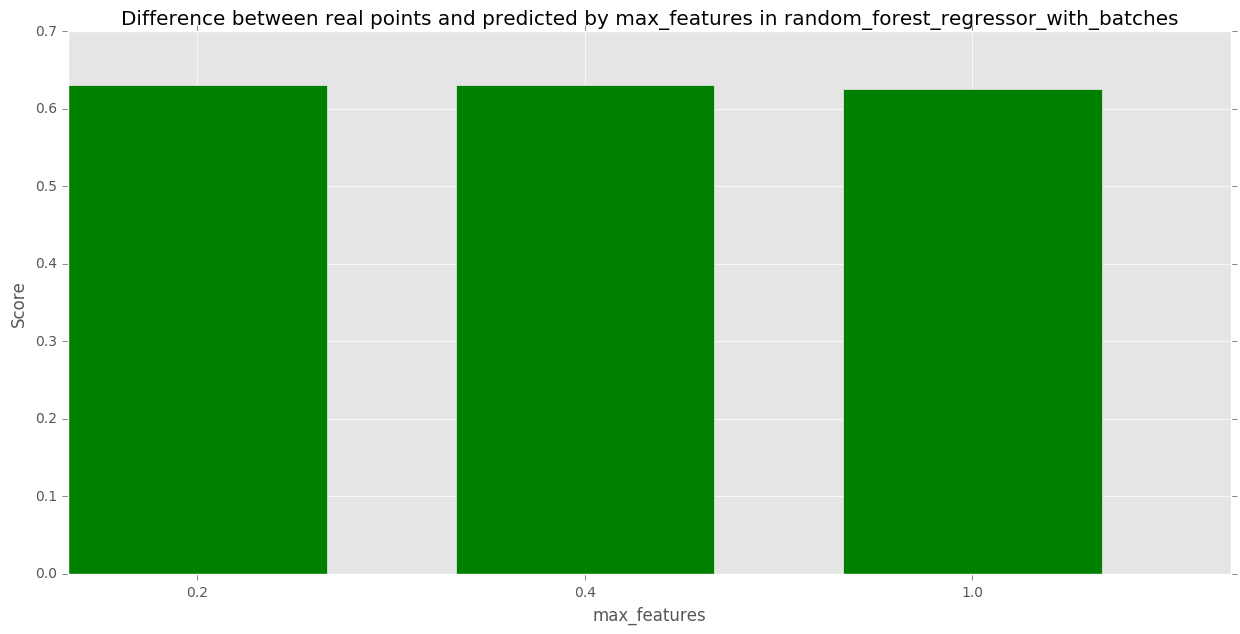

In [43]:
compare_results(function=random_forest_regressor_with_batches, test_results=train_results, parameter_name="max_features",
                list_of_values=[0.2, 0.4, 1.0], train_data=train_data, train_results=train_results,
                test_data=train_data, prediction_mode='delta')